# Top-pop recommender, metrics

In [39]:
import json
import random
import copy
from tqdm.notebook import tqdm
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

DATA_PATH = "../botify/data/"

In [40]:
experiment = "RECOMMENDERS"
recomenders_names = {
    "C" : "Random",
    "T1": "Collaborative",
    "T2": "Contextual",
    "T3": "StickyArtist",
    "T4": "TopPop"
}
data = pd.read_json(DATA_PATH + "data_60k.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])
data["rnd"] = np.random.random(len(data))

data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment,rnd
0,next,2022-06-24 18:53:59.211,3255,2659,1.00,0.000395,1725.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4,0.170251
1,next,2022-06-24 18:53:59.222,3255,1725,0.12,0.000335,1537.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4,0.438007
2,next,2022-06-24 18:53:59.232,3255,1537,0.99,0.000333,1995.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4,0.931554
3,next,2022-06-24 18:53:59.243,3255,1995,1.00,0.000437,3590.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4,0.922898
4,next,2022-06-24 18:53:59.254,3255,3590,0.45,0.000327,8096.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4,0.281687


In [41]:
data.groupby("treatment").count()

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
treatment,,,,,,,,,
C,89252,89252,89252,89252,89252,89252,76665,89252,89252
T1,102098,102098,102098,102098,102098,102098,89427,102098,102098
T2,132383,132383,132383,132383,132383,132383,119609,132383,132383
T3,99441,99441,99441,99441,99441,99441,87261,99441,99441
T4,103659,103659,103659,103659,103659,103659,91181,103659,103659


In [42]:
dataframes_dict = dict()
recomenders = data["treatment"].unique()
for recomender in recomenders:
    dataframes_dict[recomender] = data.loc[data["treatment"] == recomender].copy()

## Compute track popularity

In [43]:
track_popularity_dict = dict()
for recomender in recomenders:
    df = dataframes_dict[recomender] 
    track_popularity = (
        df[df["rnd"] > 0.5]
        .groupby("track")["time"]
        .sum()
        .to_frame()
        .sort_values("time", ascending=False)
        .reset_index()
    )
    track_popularity_dict[recomender] = track_popularity.copy()
    print(recomender, track_popularity_dict[recomender].head(), sep='\n')

T4
   track    time
0    176  230.15
1    171  218.93
2    424  208.89
3    177  208.45
4   7585  207.77
C
   track   time
0    177  16.80
1    171  16.07
2    442  16.01
3    443  16.00
4   4205  16.00
T1
   track   time
0    246  52.85
1    443  52.78
2    171  47.41
3    177  46.21
4    424  42.99
T3
   track   time
0   6808  20.62
1   2795  20.50
2   1829  18.13
3   4205  17.00
4   4267  15.63
T2
   track    time
0    176  345.84
1    246  343.30
2   7585  283.51
3    175  261.14
4   1998  259.08


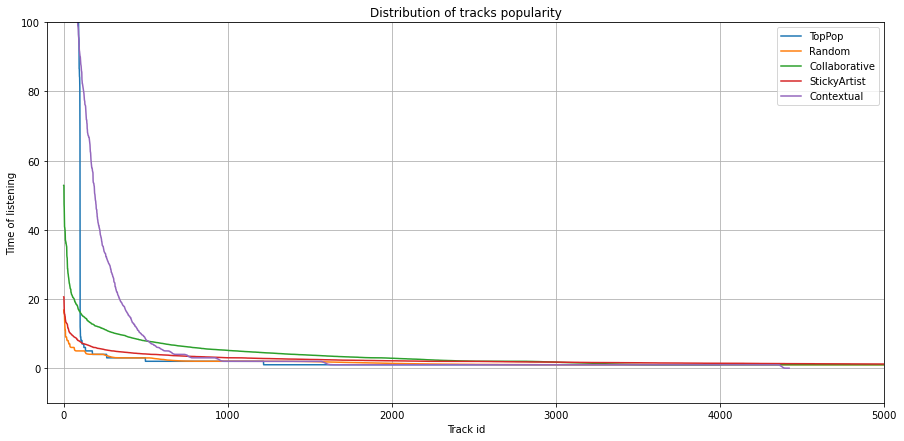

In [44]:
fig, ax = plt.subplots(figsize=(15, 7))
for recomender in recomenders:
    ax.plot(track_popularity_dict[recomender].index.values, 
            track_popularity_dict[recomender]["time"].values, 
            label=recomenders_names[recomender])
ax.set_xlim(left=-100, right=5000)
ax.set_ylim(bottom=-10, top=100)
ax.set_title("Distribution of tracks popularity")
ax.set_xlabel("Track id")
ax.set_ylabel("Time of listening")
ax.grid(True)
ax.legend();

## Compute offline metrics

In [45]:
metrics_dict = dict()
tracks_dict = dict()
for recomender in recomenders:
    df = dataframes_dict[recomender]
    tracks_dict[recomender] = track_popularity_dict[recomender]["track"].tolist()
    metrics_dict[recomender] = df[(df["rnd"] <= 0.5) & (df["time"] >= 0.75)].copy()

In [46]:
def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)


# TODO 1: Implement MRR here:
def mrr(recommendations, track):
    return 1.0 / (1.0 + recommendations.index(track)) if track in recommendations else 0.0

def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

### 1. Precision@k

In [47]:
for recomender in tqdm(recomenders):
    p_10_udf = lambda track: precision_at(tracks_dict[recomender][:10], track, 10)
    sh_10_p_10_udf = lambda track: shuffled_precision_at(tracks_dict[recomender][:10], track, 10)
    sh_100_p_10_udf = lambda track: shuffled_precision_at(tracks_dict[recomender][:100], track, 10)
    sh_1000_p_10_udf = lambda track: shuffled_precision_at(tracks_dict[recomender][:1000], track, 10)
    
    metrics_dict[recomender]["p_10"] = metrics_dict[recomender]["track"].map(p_10_udf)
    metrics_dict[recomender]["sh_10_p_10"] = metrics_dict[recomender]["track"].map(sh_10_p_10_udf)
    metrics_dict[recomender]["sh_100_p_10"] = metrics_dict[recomender]["track"].map(sh_100_p_10_udf)
    metrics_dict[recomender]["sh_1000_p_10"] = metrics_dict[recomender]["track"].map(sh_1000_p_10_udf)

  0%|          | 0/5 [00:00<?, ?it/s]

In [48]:
for recomender in recomenders:
    print(recomenders_names[recomender], 
          metrics_dict[recomender][["p_10", "sh_10_p_10", "sh_100_p_10", "sh_1000_p_10"]].describe(), 
          sep='\n')

TopPop
               p_10    sh_10_p_10   sh_100_p_10  sh_1000_p_10
count  17717.000000  17717.000000  17717.000000  17717.000000
mean       0.009849      0.009849      0.006790      0.000751
std        0.029799      0.029799      0.025158      0.008632
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000
75%        0.000000      0.000000      0.000000      0.000000
max        0.100000      0.100000      0.100000      0.100000
Random
               p_10    sh_10_p_10   sh_100_p_10  sh_1000_p_10
count  10461.000000  10461.000000  10461.000000  10461.000000
mean       0.001090      0.001090      0.000401      0.000191
std        0.010383      0.010383      0.006324      0.004369
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.0

### 2. MRR

In [49]:
for recomender in tqdm(recomenders):
    # TODO 2: Apply MRR here:
    mrr_10_udf = lambda track: mrr(tracks_dict[recomender][:10], track)
    sh_10_mrr_10_udf = lambda track: shuffled_mrr(tracks_dict[recomender][:10], track)
    sh_100_mrr_10_udf = lambda track: shuffled_mrr(tracks_dict[recomender][:100], track)
    sh_1000_mrr_10_udf = lambda track: shuffled_mrr(tracks_dict[recomender][:1000], track)
    
    metrics_dict[recomender]["mrr_10"] = metrics_dict[recomender]["track"].map(mrr_10_udf)
    metrics_dict[recomender]["sh_10_mrr_10"] = metrics_dict[recomender]["track"].map(sh_10_mrr_10_udf)
    metrics_dict[recomender]["sh_100_mrr_10"] = metrics_dict[recomender]["track"].map(sh_100_mrr_10_udf)
    metrics_dict[recomender]["sh_1000_mrr_10"] = metrics_dict[recomender]["track"].map(sh_1000_mrr_10_udf)

  0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
for recomender in recomenders:
    print(recomenders_names[recomender], 
          metrics_dict[recomender][["mrr_10", "sh_10_mrr_10", "sh_100_mrr_10", "sh_1000_mrr_10"]].describe(),
          sep='\n')

TopPop
             mrr_10  sh_10_mrr_10  sh_100_mrr_10  sh_1000_mrr_10
count  17717.000000  17717.000000   17717.000000    17717.000000
mean       0.030027      0.028526       0.035206        0.005861
std        0.124129      0.118574       0.101616        0.036444
min        0.000000      0.000000       0.000000        0.000000
25%        0.000000      0.000000       0.000000        0.000000
50%        0.000000      0.000000       0.013514        0.001493
75%        0.000000      0.000000       0.027027        0.002985
max        1.000000      1.000000       1.000000        1.000000
Random
             mrr_10  sh_10_mrr_10  sh_100_mrr_10  sh_1000_mrr_10
count  10461.000000  10461.000000   10461.000000    10461.000000
mean       0.003570      0.002658       0.002279        0.001283
std        0.045793      0.033469       0.026557        0.017412
min        0.000000      0.000000       0.000000        0.000000
25%        0.000000      0.000000       0.000000        0.000000
50%        

## Export data for prod

In [51]:
for recomender in recomenders:
    print(recomenders_names[recomender],
         len(tracks_dict[recomender]),
         sep = '\n')

TopPop
4002
Random
28231
Collaborative
9664
StickyArtist
18190
Contextual
4421


In [52]:
for recomender in recomenders:
    with open(DATA_PATH + f"top_tracks_{recomenders_names[recomender]}.json", "w") as top_tracks_file:
        json.dump(track_popularity_dict[recomender]["track"].tolist(), top_tracks_file)